In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
from datetime import timedelta, date, datetime
import matplotlib.pyplot as plt
from principle3_1 import data
from principle3_1.scheduling import average_scheduler, optimal_scheduler


In [2]:
germany_2017 = data.load_data_germany2017_local("./principle3_1/data")

germany_2017.head()

   Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
0           0             0               0                 0   
1           1             1               1                 1   
2           2             2               2                 2   
3           3             3               3                 3   
4           4             4               4                 4   

   Unnamed: 0.1.1.1.1  Unnamed: 0.1.1.1.1.1  Unnamed: 0.1.1.1.1.1.1  \
0                   0                     0                   94969   
1                   1                     1                   94970   
2                   2                     2                   94971   
3                   3                     3                   94972   
4                   4                     4                   94973   

        utc_timestamp  price  
0 2016-11-01 00:00:00  33.68  
1 2016-11-01 01:00:00  33.31  
2 2016-11-01 02:00:00  32.52  
3 2016-11-01 03:00:00  32.99  
4 2016-11-01 04:00:00  33.3

In [ ]:
# helper functions for the average scheduler

# access hourly price at a certain point in time
def get_price_data(data, timepoint):
    return data[data['utc_timestamp'] == timepoint]['price'].values[0]

# access average hourly energy price for a certain time window
def get_avg_price(data, start, end):
    temp_data = data[data["utc_timestamp"] >= start]
    temp_data = temp_data[temp_data['utc_timestamp'] < end]
    return temp_data.mean().values[0]

# the rule by which teh average scheduler decides when to advance the computation
def average_scheduling_rule(price, avg_price, percentage=1.):
    """
    Implements rule bz which average scheduler decides to execute one hour of the scheduled computation.
    """
    return price < avg_price * percentage

In [ ]:
#now for the scheduler itself
def average_scheduler(net_computing_time, slack, data, start_time, percentage = 1):
    """
    Applies the average scheduling scheme described in the paper using the average price of the last 61 days
    (about two months) as a baseline for the decision
    :param net_computing_time:  timedelta
    :param slack: float
    :param data: pandas.DataFrame
    :param start_time: datetime
    :param percentage float
    :return: (float, float)
    """
    # in the beginning the remaining computing time is teh net computing time
    remaining_time = net_computing_time
    estimated_end = start_time + remaining_time
    # the latest possible end is defined by the net computing time and the amount of slack
    latest_end = start_time + net_computing_time * (1 + slack)
    payed = 0
    # time window to calculate average past price
    time_window = timedelta(days=61)
    avg_price = get_avg_price(data, start_time - time_window, start_time)
    now = start_time
    # while still computing time remaining (i.e. while computation not finished)
    while remaining_time > timedelta(days=0, hours=0):
        # get current hourly price

        current_price = get_price_data(data, now)
        # if there is still slack left
        if estimated_end < latest_end:
            # if current price below limit given by rule
            if average_scheduling_rule(current_price, avg_price,percentage):
                # add current price to amount payed
                payed += current_price
                # reduce remaining time by one hour (i.e. compute for one hour)
                remaining_time -= timedelta(hours=1)
            else:
                # else advance estimated end for one hour (i.e. process idle for one hour)
                estimated_end = estimated_end + timedelta(hours=1)
        else:
            # if no slack: advance computation and pay price
            payed += current_price
            remaining_time -= timedelta(hours=1)
        # advance one hour
        now += timedelta(hours=1)

    end = now

    return payed, end - start_time


In [ ]:
def optimal_scheduler(net_computing_time,slack,data,start_time):
    """
    Calculates an ideal energy cost saving using slack, given the prices are known in advance.
        :param net_computing_time:  timedelta
        :param slack: float
        :param data: pandas.DataFrame
        :param start_time: datetime
        :return: (float, float)
        """
    # calculate maximum time window
    latest_end = start_time + net_computing_time * (1 + slack)
    # extract price data of maximum time window
    data = data[data["utc_timestamp"] >= start_time]
    data = data[data["utc_timestamp"] < latest_end.replace(microsecond=0, second=0, minute=0)]
    # sort data by price
    sorted = data.sort_values(by="price")
    prices = np.asarray(sorted["price"].values)
    process_duration = int(np.floor(net_computing_time.total_seconds() / 3600))
    # sum n lowest prices where n is the net computation time
    price = np.sum(prices[:process_duration])
    end = sorted["utc_timestamp"].iloc[:process_duration].max()
    return price, end - start_time


In [ ]:
# now we define our test parameters

# slack values we want to test (1.0 equals 100% slack)
slacks = [.0, .1, .25, .5, 1.0]

# net computation time of our tasks we want to test for
net_computation_time = [timedelta(hours=5), timedelta(hours=10), timedelta(hours=20), timedelta(hours=40), timedelta(hours=80), timedelta(hours=160)]
# the earliest day of the test (in the current configuration of the data set,
# January 1st 2017 is the earliest possible date)
start_date = datetime(2017,1,1)
# the last day of the test (in the current configuration of the data set and net_computation times,
# December 24th 2017 is the latest possible date)
end_data = datetime(2017, 12, 24)

# the rate at which to step forward after each evaluation (the smaller it is, the more samples are tested, 1 hour is a realistic minimum)
time_skip = timedelta(days=1, hours=1)


In [ ]:
# now we iterate through the available data to calculate the energy savings for each task duration, slack value and start data.
as_results = df()
os_results = df()
while start_date < datetime(2017, 12, 24):
    for duration in durations:
         p_fix, t_fix = average_scheduler(duration, 0.0, germany_2017, start_date)
         for slack in slacks:
             p_slack,t_slack = average_scheduler(duration, slack, germany_2017, start_date, percentage = 1)
             add_time = (t_slack.total_seconds() - t_fix.total_seconds())/(t_fix.total_seconds())
             saved_money = (p_fix - p_slack) / p_fix
             temp_data = df(columns=["start_date", "duration", "slack", "money_saved", "additional_time","new_price", "new_duration","original_price","original_duration"])
             temp_data.loc[0] = [start_date, duration, slack, saved_money, add_time, p_slack, t_slack.total_seconds(), p_fix, t_fix.total_seconds()]
             if as_results.empty:
                 as_results = temp_data
             else:
                 as_results = as_results.append(temp_data,  ignore_index=True)
    start_date += timedelta(days=1, hours=1)

In [ ]:
# this took some time, so lets 
as_results.to_csv("./data/as_energy_cost_savings.csv")
os_results.to_csv("./data/os_energy_cost_savings.csv")

In [ ]:
slacks = [.0, .1, .25,  1.0]
durations = [timedelta(hours=5), timedelta(hours=10), timedelta(hours=20), timedelta(hours=40), timedelta(hours=80), timedelta(hours=160)]
start_date = datetime(2017, 1, 1)
os_results = df()
while start_date < datetime(2017, 12, 24):
    for duration in durations:
         p_fix, t_fix = optimal_scheduler(duration, 0.0, germany_2017, start_date)
         for slack in slacks:
             p_slack,t_slack = optimal_scheduler(duration, slack, germany_2017, start_date)
             add_time = (t_slack.total_seconds() - t_fix.total_seconds())/(t_fix.total_seconds())
             saved_money = (p_fix - p_slack) / p_fix
             temp_data = df(columns=["start_date", "duration", "slack", "money_saved", "additional_time","new_price", "new_duration","original_price","original_duration"])
             temp_data.loc[0] = [start_date, duration, slack, saved_money, add_time, p_slack, t_slack.total_seconds(), p_fix, t_fix.total_seconds()]
             if os_results.empty:
                 os_results = temp_data
             else:
                 os_results = os_results.append(temp_data,  ignore_index=True)
                
    start_date += timedelta(days = 1, hours = 1)

In [ ]:
# this took some time, so lets 
os_results.to_csv("./data/os_energy_cost_savings.csv")


In [ ]:
# If you did the previous computations once you can now load the intermediate results

# load results of average and optimal scheduler
as_results = pd.read_csv("./data/as_energy_cost_savings.csv",infer_datetime_format=True)
os_results = pd.read_csv("./data/os_energy_cost_savings.csv",infer_datetime_format=True)

# transform time information back to datetime.timedelta format (this is lost when loading)
as_results["duration"] = pd.to_timedelta(as_results["duration"])
os_results["duration"] = pd.to_timedelta(os_results["duration"])

# transform duration into hours
as_results["duration"] = as_results["duration"].apply(lambda x: int(x.total_seconds()/3600))                                                    
os_results["duration"] = os_results["duration"].apply(lambda x: int(x.total_seconds()/3600))

In [ ]:
# goup the data by net computation time and slack and compute the mean of all other columns over these groups
as_results_mean = as_results.groupby(["duration","slack"],as_index=False).mean()
os_results_mean = os_results.groupby(["duration","slack"],as_index=False).mean()


In [ ]:
# isolate different net computation times
measurementPonts=[10,40,160]
ash={str(k):as_results_mean[as_results_mean["duration"] == 10] for k in measurementPoints}
osh={str(k):as_results_mean[as_results_mean["duration"] == 10] for k in measurementPoints}

as_10h = as_results_mean[as_results_mean["duration"] == 10]
as_40h = as_results_mean[as_results_mean["duration"] == 40]
as_160h = as_results_mean[as_results_mean["duration"] == 160]
os_10h = os_results_mean[os_results_mean["duration"] == 10]
os_40h = os_results_mean[os_results_mean["duration"] == 40]
os_160h = os_results_mean[os_results_mean["duration"] == 160]

In [ ]:
# isolate different slack factors times
as_01 = as_results_mean[as_results_mean["slack"] == 0.1]
as_025 = as_results_mean[as_results_mean["slack"] == 0.25]
as_1 = as_results_mean[as_results_mean["slack"] == 1.] 
os_01 = os_results_mean[os_results_mean["slack"] == 0.1]
os_025 = os_results_mean[os_results_mean["slack"] == 0.25]
os_1 = os_results_mean[os_results_mean["slack"] == 1.] 


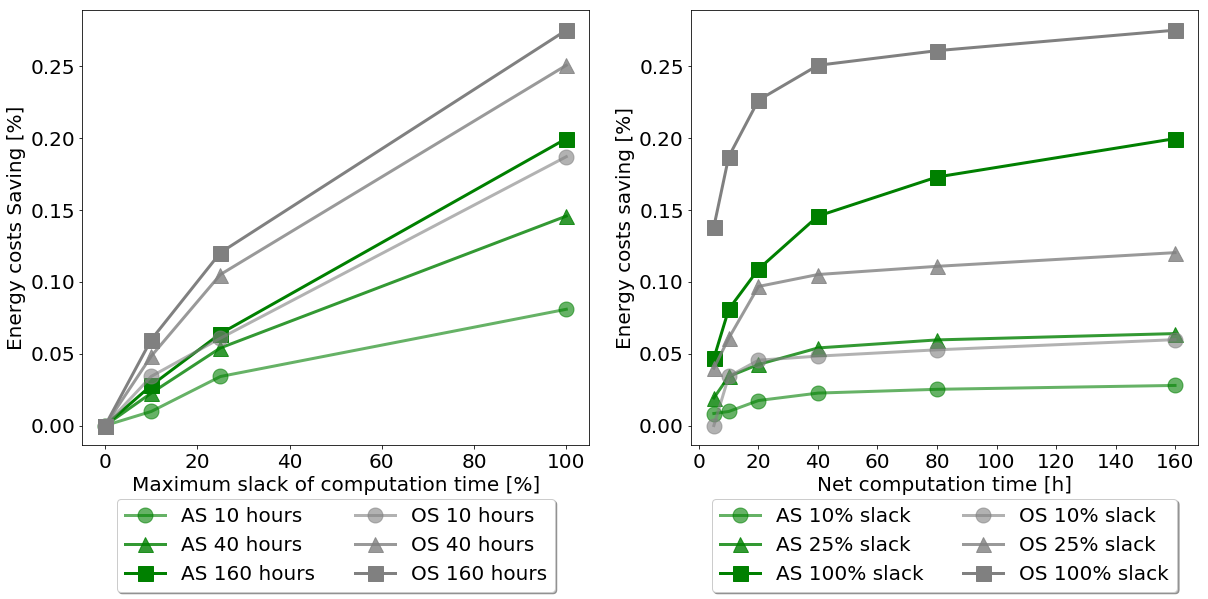

In [ ]:
marker = 15
line = 3
fig, axs = plt.subplots(1, 2,figsize =[20, 8])
slacks = as_results_mean["slack"].drop_duplicates().values * 100
durations = as_results_mean["duration"].drop_duplicates().values

#LOOP
axs[0].plot(slacks, as_10h["money_saved"].values, "o-",label="AS 10 hours", markersize=marker,linewidth=line,  color = "green", alpha=0.6)
axs[0].plot(slacks, as_40h["money_saved"].values, "^-",label="AS 40 hours", markersize=marker,linewidth=line, color = "green", alpha=0.8)
axs[0].plot(slacks, as_160h["money_saved"].values, "s-",label="AS 160 hours", markersize=marker,linewidth=line,color = "green", alpha=1)

axs[0].plot(slacks, os_10h["money_saved"].values, "o-",label="OS 10 hours",  markersize=marker,linewidth=line,color = "grey", alpha=0.6)
axs[0].plot(slacks, os_40h["money_saved"].values, "^-",label="OS 40 hours",  markersize=marker,linewidth=line,color = "grey", alpha=0.8)
axs[0].plot(slacks, os_160h["money_saved"].values, "s-",label="OS 160 hours",  markersize=marker,linewidth=line, color = "grey", alpha=1)

axs[0].set_ylabel("Energy costs Saving [%]")
axs[0].set_xlabel("Maximum slack of computation time [%]")
lgd1 = axs[0].legend(fontsize = 20,loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)
for item in ([axs[0].title, axs[0].xaxis.label, axs[0].yaxis.label] +
             axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    item.set_fontsize(20)

axs[1].plot(durations, as_01["money_saved"].values, "o-", label="AS 10% slack", markersize=marker,linewidth=line, color = "green", alpha=0.6)
axs[1].plot(durations, as_025["money_saved"].values, "^-", label="AS 25% slack", markersize=marker, linewidth=line,color = "green", alpha=0.8)
axs[1].plot(durations, as_1["money_saved"].values, "s-", label="AS 100% slack", markersize=marker,linewidth=line, color = "green", alpha=1)

axs[1].plot(durations, os_01["money_saved"].values, "o-", label="OS 10% slack", markersize=marker,linewidth=line, color = "grey", alpha=0.6)
axs[1].plot(durations, os_025["money_saved"].values, "^-", label="OS 25% slack", markersize=marker,linewidth=line, color = "grey", alpha=0.8)
axs[1].plot(durations, os_1["money_saved"].values, "s-", label="OS 100% slack", markersize=marker,linewidth=line, color = "grey", alpha=1)

axs[1].set_ylabel("Energy costs saving [%]")
axs[1].set_xlabel("Net computation time [h]")
lgd2 =axs[1].legend(fontsize = 20,loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)
for item in ([axs[1].title, axs[1].xaxis.label, axs[1].yaxis.label] +
             axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    item.set_fontsize(20)
#fig.savefig("slack.jpg", bbox_extra_artists=(lgd1,lgd2), bbox_inches='tight')
plt.show()
